## Analysis of the Effectiveness of Promotion Offers for a Self-storage Company X

<h2>Introduction</h2>
Company X's customers were offered varioud types of promotions in the form of discounted monthly rent. Comapny X would like to assess the effectiveness of these promotions as a means to increase customer conversion and revenue. 

**Several questions we would like to answer:**

Q1. Estimate probabilistically the likelihood that Company X received more rentals as of result of offering promotions.

Q2. Predict the number of incremental rentals Company X would have to receive in order for the promotion plan to break even (i.e., given the cost in free rent) of each promotion.

Q3. Estimate probabilistically the likelihood Company X increased revenue when offering these promotions.

**Overall conclusions**

- Offering promotions of "First Month Free", "First Month Half Off", "Two Months Half Off" led to the increase of the conversion rate of customers from reservation to signing up for rentals.

- Offering "Three Months Half Off" or "Two Months Free" does not seem to result in an increase of the conversion rate.

- When comparing the conversion rates between "First Month Half Off" and "First Month Free", there is strong evidence that suggests "First Month Half Off" has higher conversion rate than "First Month Free". We might recommend to remove the offering of "First Month Free" since "First Month Half Off" actually produced better conversion rate.

- The revenue loss due to all promotions is calculated to be as much as 2.2 million dollars. To recover these losses, more reservations would need to be converted at each of the promotion category. Since the rent rates vary a lot, the increase in rental volume was estimated using the maximum rent rate at each promotion category. The increase in rental is calculated by the loss amount divided by the maximum rent rate. 

- Revenues from customers without and with promotions are calculated. Even though conversion rate went up, the revenue loss due to the discounted rent prices affected the overall revenue as well. Looking only at data up to 2014-6-11, the distributions of revenues for the two cases (ie. without and with promotions) are examined. Using PyMC3, we estimated the posterior distribution of the revenues. It was found that the mean revenue of rentals from promotion is less than the revenue from cases without promotions. The former is estimated to be between 63% and 66% of the mean revenue without promotion. This does not mean the revenue is always less given promotion offers. The revenue loss due to promotion/discounts do not change with the length of the customers' stay. But for the calculation of revenue, the longer the customer's stay is, the more likely the promotions would be able to bring in more revenues. Here the revenue calcaulations were done by considering only the revenue accumulated up to 2014-6-11 (ie. a maximum of 20 months). We could run simulations to extend the maximum months to 21, 22, 23 etc. to sucessively calculate at which length of stay would make the revenues from promotions higher than those without promotion. Alternatively, we could perform survival analysis to estimate the length of rental past 2014-6-11 to impute the missing 'Move out date' and consequently the future revenues. 


<h2>Table of Contents</h2>
* <a href="#clean">Data cleaning</a>
* <a href="#explore">Data exploration</a>
* <a href="#QA1">Answers to Q1</a>
* <a href="#QA2">Answers to Q2</a>
* <a href="#QA3">Answers to Q3</a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
all_data = pd.read_excel('Dataset_PromotionOffers.xlsx')

## Data cleaning <a class="anchor" id="clean"></a>

In [3]:
all_data.head()

,Store,Account ID,SquareFeet,Rented?,ReserveDate,Move In Date,Move Out Date,Promotion Name,Source,RentRate,StreetRate,Concession,Region,Previously Used Storage?,Purpose?,Storage Reason
0,3475,105000,0,False,2012-11-11 16:06:13.897,2012-11-17 06:24:08.897,NaT,NaN,Store Reservation,81.0,81.0,0.0,Inland Empire,NaN,NaN,NaN
1,4115,105001,25,False,2012-11-11 16:06:51.421,2012-11-11 00:00:27.421,NaT,NaN,Store Reservation,84.0,84.0,0.0,Ohio,NaN,NaN,NaN
2,4615,105002,200,False,2012-11-11 16:36:28.175,2012-11-11 01:07:02.175,NaT,NaN,Store Reservation,246.0,246.0,0.0,Other Southeast,NaN,NaN,NaN
3,1615,105003,300,True,2012-11-11 17:05:25.627,2012-11-11 17:05:27.627,NaT,NaN,Web Reservation,224.0,224.0,0.0,Inland Empire,No,Other,Other
4,3355,105004,50,False,2012-11-11 17:08:41.900,2012-11-13 03:37:55.900,NaT,NaN,Web Reservation,64.0,64.0,0.0,Inland Empire,NaN,NaN,NaN


In [4]:
print("There are %d entries in the data" %(all_data.shape[0]))

There are 58664 entries in the data


In [5]:
# Idenfies unusual dates in the data
movein_date=pd.to_datetime(all_data['Move In Date'],format='%Y-%m-%d %H:%M:%S')
bad_data=all_data[all_data['Move In Date'] < pd.to_datetime('2012-1-1 00:00:00.000000',format='%Y-%m-%d %H:%M:%S')]
print(bad_data['Move In Date'])
print("There are %d entries with bad 'Move In Date' data"%(bad_data.shape[0]))

34134   1899-06-23 16:39:45.000
41018   1899-06-12 03:37:11.986
45235   1899-07-13 21:57:42.827
54590   1899-10-22 19:05:46.000
55905   1899-10-11 00:30:17.811
56272   1899-11-05 00:46:26.000
Name: Move In Date, dtype: datetime64[ns]
There are 6 entries with bad 'Move In Date' data


In [6]:
# Replace NaN with text
all_data['Promotion Name'].fillna('No promo',inplace=True)
all_data['Previously Used Storage?'].fillna('No info',inplace=True)

## Data exploration <a class="anchor" id="explore"></a>

In [7]:
# drop entries where the dates are bad
all_data=all_data[all_data['Move In Date'] > pd.to_datetime('2012-1-1 00:00:00.000000',format='%Y-%m-%d %H:%M:%S')]

rent_count=all_data['Rented?'].value_counts()
print("%d reservations are rented"%rent_count[1])
print("%d reservations are not rented"%rent_count[0])

36688 reservations are rented
21970 reservations are not rented


In [8]:
# look at different types of reservations
source_count=all_data['Source'].value_counts()
print(source_count)

Web Reservation             20821
Store Reservation           19047
Sales Center Reservation    18790
Name: Source, dtype: int64


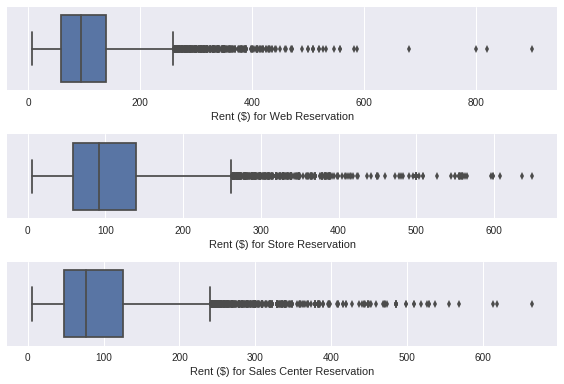

In [9]:
# look at whether the rent rate varies for different reservations
ax = plt.subplot(3,1,1)
sns.boxplot(np.array(all_data[all_data['Source']=='Web Reservation']['RentRate']))
plt.xlabel('Rent ($) for Web Reservation')
ax = plt.subplot(3,1,2)
sns.boxplot(np.array(all_data[all_data['Source']=='Store Reservation']['RentRate']))
plt.xlabel('Rent ($) for Store Reservation')
ax = plt.subplot(3,1,3)
sns.boxplot(np.array(all_data[all_data['Source']=='Sales Center Reservation']['RentRate']))
plt.xlabel('Rent ($) for Sales Center Reservation')
plt.tight_layout()
plt.show()

In [10]:
print("%d entries with cost > $600"%len(all_data[all_data['RentRate']>600]))
print("%d entries with cost < $10"%len(all_data[all_data['RentRate']<10]))

10 entries with cost > $600
108 entries with cost < $10


In [11]:
# Look at promotion types 
promo_type = all_data['Promotion Name'].value_counts()
promo_type_rented = all_data[all_data['Rented?']==True]['Promotion Name'].value_counts()

df=pd.concat([promo_type,promo_type_rented],axis=1)
df.fillna(0,inplace=True)
df.columns=['offered','rented']
percentage=df['rented']/df['offered']
df=pd.concat([df,percentage],axis=1)
df.columns=['offered','rented','conversion ratio']
print("How many reservations are converted into successful rentals by different promotions:")
print()
print(df)

How many reservations are converted into successful rentals by different promotions:

                       offered   rented  conversion ratio
First Month Free         33292  22179.0          0.666196
First Month Half Off      4268   2950.0          0.691190
No promo                 19787  11278.0          0.569970
Three Months Half off      670      0.0          0.000000
Two Months Free            312     59.0          0.189103
Two Months Half Off        329    222.0          0.674772


## Answer to Q1 <a class="anchor" id="QA1"></a>
Estimate probabilistically the likelihood that Company X received more rentals as of result of offering promotions.

Given the above conversion ratios, our hypothesis is that, promotions did not increase the conversion ratio from that of the control group (ie. no promotion). To test the significance of the above samples (assuming they are all independent of each other), we use the two proportion z-test.

In [12]:
promo_type = df.index.values
print(promo_type)

['First Month Free' 'First Month Half Off' 'No promo'
 'Three Months Half off' 'Two Months Free' 'Two Months Half Off']


In [13]:
from statsmodels.stats.proportion import proportions_ztest

for name_promo in promo_type:
    if name_promo !='No promo':

    ## 
        print(name_promo)
        count=np.array([df.loc['No promo']['rented'],df.loc[name_promo]['rented']])
        nobs=np.array([df.loc['No promo']['offered'],df.loc[name_promo]['offered']])

        z,p = proportions_ztest(count, nobs, value=0, alternative='smaller')
        print(' \t z-stat = {z} \n\t p-value = {p}'.format(z=z,p=p))

First Month Free
 	 z-stat = -22.207421571713095 
	 p-value = 1.4558735677304264e-109
First Month Half Off
 	 z-stat = -14.611573574032127 
	 p-value = 1.1849026129476461e-48
Three Months Half off
 	 z-stat = 29.17338055505373 
	 p-value = 1.0
Two Months Free
 	 z-stat = 13.461016339901255 
	 p-value = 1.0
Two Months Half Off
 	 z-stat = -3.8100084577432316 
	 p-value = 6.948101889454067e-05


In [14]:
count=np.array([df.loc['First Month Half Off']['rented'],df.loc['First Month Free']['rented']])
nobs=np.array([df.loc['First Month Half Off']['offered'],df.loc['First Month Free']['offered']])
print('Compare First Month Half Off vs. First Month Free:')
z,p = proportions_ztest(count, nobs, value=0, alternative='larger')
print(' \t z-stat = {z} \n\t p-value = {p}'.format(z=z,p=p))

Compare First Month Half Off vs. First Month Free:
 	 z-stat = 3.266954014874621 
	 p-value = 0.0005435566863699567


** Observations **

First, the highest conversion rate appears to be from the "First Month Half Off" promotion, at 69%. There is zero conversion of reservations for the "Three Months Half off" promotion. 

By using two proportion z-test comparing each promotion samples to the samples without promotion, we obtained the p value which is the probability of observing the samples at least as extreme as the one in our sample data assuming the hypothesis is true. The extremely low p-value in cases "First Month Free", "First Month Half Off" and "Two Months Half Off" indicate that the hypothesis that the two samples are from the same distribution can be rejected. The alternative hypothesis is that the conversion rate of "No promotion" samples is smaller than that of these three promotions (since we used one-sided hypothesis testing). 

In cases of "Three Months Half Off" and "Two Months Free", we reject the alternative hypothesis which is also obvious from the calculated conversion values already.

When comparing the conversion rates between "First Month Half Off" and "First Month Free", there is strong evidence that suggests "First Month Half Off" has higher conversion rate than "First Month Free".

## Answer to Q2 <a class="anchor" id="QA2"></a>

Predict the number of incremental rentals Company X would have to receive in order for the promotion plan to break even (i.e., given the cost in free rent) of each promotion.

In [15]:
# Look at promotion types again
print(df)

                       offered   rented  conversion ratio
First Month Free         33292  22179.0          0.666196
First Month Half Off      4268   2950.0          0.691190
No promo                 19787  11278.0          0.569970
Three Months Half off      670      0.0          0.000000
Two Months Free            312     59.0          0.189103
Two Months Half Off        329    222.0          0.674772


In [16]:
# define multiplication factors which are equal to the discount in months, e.g. 0.5 is half month free.
promo_cost_factor={}
promo_cost_factor['No promo']=0
promo_cost_factor['First Month Half Off']=0.5
promo_cost_factor['First Month Free']=1
promo_cost_factor['Two Months Half Off']=1
promo_cost_factor['Two Months Free']=2
promo_cost_factor['Three Months Half off']=3/2
print(promo_cost_factor)

{'No promo': 0, 'First Month Half Off': 0.5, 'First Month Free': 1, 'Two Months Half Off': 1, 'Two Months Free': 2, 'Three Months Half off': 1.5}


In [17]:
# calculate total revenue lost due to discounts
rented_data=all_data[all_data['Rented?']==True]
promo_type = df.index.values

lost_rev_df=pd.DataFrame(index=np.arange(len(promo_cost_factor)),columns=['name_promo','num_transactions','factor','lost revenue($)'])

i=0

for name_promo in promo_type:
    
    lost_rev_df.loc[i]['name_promo']=name_promo
    transactions=rented_data[rented_data['Promotion Name']==name_promo]['RentRate']
    lost_rev_df.loc[i]['num_transactions']=len(transactions)
    lost_rev_df.loc[i]['factor']=promo_cost_factor[name_promo]
    lost_rev_df.loc[i]['lost revenue($)'] = sum(np.array(transactions)*promo_cost_factor[name_promo])
    
    i +=1    
    
print(lost_rev_df)
total_lost_rev=sum(lost_rev_df['lost revenue($)'])
print()
print('total lost revenue = $ %d' %total_lost_rev)

              name_promo num_transactions factor lost revenue($)
0       First Month Free            22179      1     2.04408e+06
1   First Month Half Off             2950    0.5          153401
2               No promo            11278      0               0
3  Three Months Half off                0    1.5               0
4        Two Months Free               59      2          7651.9
5    Two Months Half Off              222      1         18076.4

total lost revenue = $ 2223207


In [18]:
print('To recover the lost revenue, we need to increase rentals. The number of increase is calculated as loss divided the maximum rent rate:')
print()
i=0
for name_promo in promo_type:
    if name_promo != 'No promo' and name_promo !='Three Months Half off':
        print("For promotion type '%s'"%name_promo)
        transactions=rented_data[rented_data['Promotion Name']==name_promo]['RentRate']
        p1=np.min(transactions)
        p3=np.max(transactions)
        p2=np.mean(transactions)
        print("  [mean avg max] rents = [$%d $%d $%d]"%(p1,p2,p3))
        print("\t at minimum, numebr of rentals should increase by %d"%(lost_rev_df.loc[i]['lost revenue($)']/p3))
        print()
    i += 1

To recover the lost revenue, we need to increase rentals. The number of increase is calculated as loss divided the maximum rent rate:

For promotion type 'First Month Free'
  [mean avg max] rents = [$6 $92 $458]
	 at minimum, numebr of rentals should increase by 4463

For promotion type 'First Month Half Off'
  [mean avg max] rents = [$12 $104 $359]
	 at minimum, numebr of rentals should increase by 427

For promotion type 'Two Months Free'
  [mean avg max] rents = [$16 $64 $269]
	 at minimum, numebr of rentals should increase by 28

For promotion type 'Two Months Half Off'
  [mean avg max] rents = [$21 $81 $199]
	 at minimum, numebr of rentals should increase by 90



## Answer to Q3 <a class="anchor" id="QA3"></a>

 Estimate probabilistically the likelihood Company X increased revenue when offering these promotions.

In the original data, the empty "Move Out Date" is assumed to be 2014-6-12, meaning those rentals have lasted until then, and possibly longer. Also, customer lease terms are all month to month (i.e., a customer can leave at any time), and customers are billed on a full month basis, rounding up to the next month. The following code calculates the number of months for each rental. 

In [19]:
def calc_number_of_months(start_date, final_date):
    if final_date < start_date:
    #    print('ERROR: dates are not increasing.')
        return 0
    delta_t=pd.date_range(start=start_date,end=final_date,freq='M')
    #  print(delta_t)
    a=len(delta_t)
    if a == 0 : 
        b=a+1
    elif start_date == final_date:
        b=a
    elif final_date.day > start_date.day and final_date != delta_t[-1]:
        b = a+1
    elif start_date == delta_t[0] and final_date == delta_t[-1] and start_date.year != final_date.year:
        b=a-1
    else:
        b=a
        
    return b

# Perform tests
# test 0
start_date=pd.to_datetime('2013-12-30 00:00:00.000000',format='%Y-%m-%d %H:%M:%S')
final_date=pd.to_datetime('2012-12-30 00:00:00.000000',format='%Y-%m-%d %H:%M:%S')
if calc_number_of_months(start_date, final_date) ==0:
    print('Pass test 0')
# test 1
start_date=pd.to_datetime('2013-12-30 00:00:00.000000',format='%Y-%m-%d %H:%M:%S')
final_date=pd.to_datetime('2013-12-30 00:00:00.000000',format='%Y-%m-%d %H:%M:%S')
if calc_number_of_months(start_date, final_date) ==1:
    print('Pass test 1')
# test 2
start_date=pd.to_datetime('2013-12-2 00:00:00.000000',format='%Y-%m-%d %H:%M:%S')
final_date=pd.to_datetime('2013-12-3 00:00:00.000000',format='%Y-%m-%d %H:%M:%S')
if calc_number_of_months(start_date, final_date) ==1:
    print('Pass test 2')
# test 3
start_date=pd.to_datetime('2013-12-2 00:00:00.000000',format='%Y-%m-%d %H:%M:%S')
final_date=pd.to_datetime('2014-12-2 00:00:00.000000',format='%Y-%m-%d %H:%M:%S')
if calc_number_of_months(start_date, final_date) ==12:
    print('Pass test 3')
# test 4
start_date=pd.to_datetime('2013-12-2 00:00:00.000000',format='%Y-%m-%d %H:%M:%S')
final_date=pd.to_datetime('2014-12-3 00:00:00.000000',format='%Y-%m-%d %H:%M:%S')
if calc_number_of_months(start_date, final_date) ==13:
    print('Pass test 4')
# test 5
start_date=pd.to_datetime('2013-12-30 00:00:00.000000',format='%Y-%m-%d %H:%M:%S')
final_date=pd.to_datetime('2014-12-30 00:00:00.000000',format='%Y-%m-%d %H:%M:%S')
if calc_number_of_months(start_date, final_date) ==12:
    print('Pass test 5')
# test 6
start_date=pd.to_datetime('2013-11-30 00:00:00.000000',format='%Y-%m-%d %H:%M:%S')
final_date=pd.to_datetime('2013-12-30 00:00:00.000000',format='%Y-%m-%d %H:%M:%S')
if calc_number_of_months(start_date, final_date) ==1:
    print('Pass test 6')

Pass test 0
Pass test 1
Pass test 2
Pass test 3
Pass test 4
Pass test 5
Pass test 6


In [20]:
rented_data=all_data[all_data['Rented?']==True]
rented_data_nopromo=rented_data[rented_data['Promotion Name']=='No promo']

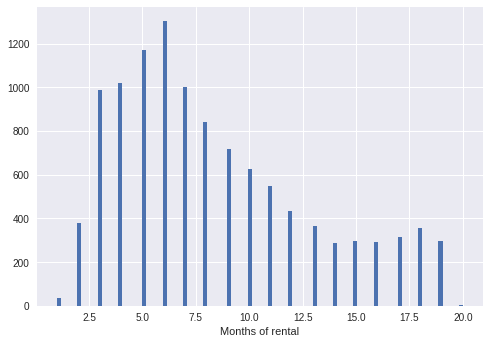

In [21]:
rented_data_select=rented_data_nopromo
rent_length_select=[]
for i in np.arange(len(rented_data_select)):
    if pd.isnull(rented_data_select.iloc[i]['Move Out Date']) and rented_data_select.iloc[i]['Rented?']==True:
        final_date=pd.to_datetime('2014-6-12 00:00:00.000000',format='%Y-%m-%d %H:%M:%S')
        
    else:
        final_date=pd.to_datetime(rented_data_select.iloc[i]['Move Out Date'],format='%Y-%m-%d %H:%M:%S')

    start_date=pd.to_datetime(rented_data_select.iloc[i]['Move In Date'],format='%Y-%m-%d %H:%M:%S')
 
    num_month=calc_number_of_months(start_date, final_date)
    rent_length_select.append(num_month)

plt.hist(rent_length_select,100)
plt.xlabel('Months of rental')
plt.show()

Plots showing the distribution of revenue from customers receiving NO promotions


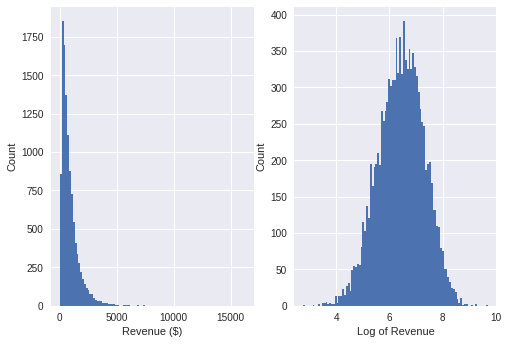

In [22]:
name_promo = 'No promo'
revenue_nopromo=[]
i=0
for price in rented_data_select['RentRate']:
    revenue_nopromo.append(price*rent_length_select[i])
    # print([i,price])
    i += 1
    
print('Plots showing the distribution of revenue from customers receiving NO promotions')
plt.subplot(1,2,1)
plt.hist(revenue_nopromo,100)
plt.xlabel('Revenue ($)')
plt.ylabel('Count')
import math
plt.subplot(1,2,2)
logval=[np.log(y) for y in revenue_nopromo]
plt.hist(logval,100)
plt.xlabel('Log of Revenue')
plt.ylabel('Count')
plt.show()

Now let us look at the rest of the customers when they were given a promotion.

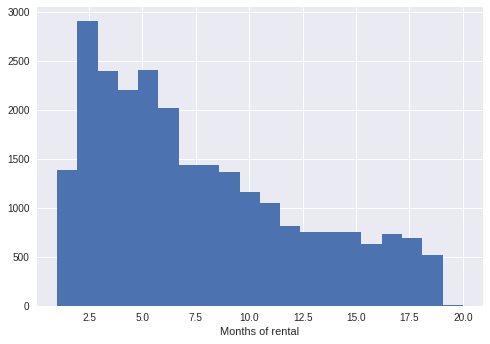

In [23]:
rented_data_wpromo=rented_data[rented_data['Promotion Name']!='No promo']
rented_data_select=rented_data_wpromo
rent_length_select=[]
for i in np.arange(len(rented_data_select)):
    if pd.isnull(rented_data_select.iloc[i]['Move Out Date']) and rented_data_select.iloc[i]['Rented?']==True:
        final_date=pd.to_datetime('2014-6-12 00:00:00.000000',format='%Y-%m-%d %H:%M:%S')
        
    else:
        final_date=pd.to_datetime(rented_data_select.iloc[i]['Move Out Date'],format='%Y-%m-%d %H:%M:%S')

    start_date=pd.to_datetime(rented_data_select.iloc[i]['Move In Date'],format='%Y-%m-%d %H:%M:%S')
 
    num_month=calc_number_of_months(start_date, final_date)
    rent_length_select.append(num_month)
    
plt.hist(rent_length_select,20)
plt.xlabel('Months of rental')
plt.show()

In [24]:
rented_data_select.head()


,Store,Account ID,SquareFeet,Rented?,ReserveDate,Move In Date,Move Out Date,Promotion Name,Source,RentRate,StreetRate,Concession,Region,Previously Used Storage?,Purpose?,Storage Reason
8,3110,105008,50,True,2012-11-11 18:04:13,2012-11-11 23:55:14,2013-02-07 17:32:44.000,First Month Half Off,Sales Center Reservation,53.1,59.0,-0.1,Colorado / Utah,No,Other,Other
17,2570,105017,100,True,2012-11-11 19:37:59,2012-12-09 03:16:10,2013-05-17 17:02:35.500,First Month Free,Sales Center Reservation,56.7,63.0,-0.1,Other Southeast,No,Organizing / Creating More Living Space,Files / Office Items
24,2715,105024,25,True,2012-11-11 20:32:25,2012-11-12 02:42:42,NaT,First Month Free,Sales Center Reservation,58.0,58.0,0.0,Baltimore / DC,Yes,Other,Files / Office Items
30,2800,105030,25,True,2012-11-11 20:59:47,2012-11-11 23:21:41,NaT,First Month Half Off,Sales Center Reservation,75.6,84.0,-0.1,Ohio,No,Moving (includes college & military deployment),Furniture / Household goods / Appliances
39,3090,105039,50,True,2012-11-11 22:04:15,2012-11-11 22:58:30,2012-12-11 09:01:07.500,First Month Free,Store Reservation,35.1,39.0,-0.1,Colorado / Utah,No,Organizing / Creating More Living Space,Files / Office Items


Notice in the 5th entry above (store 3090, Account 105039), the Move Out Date is exactly one month from the Move In Date, and it received 'First Month Free' promotion!! Cases like this would mean zero revenue!

Plots showing the distribution of revenue from customers receiving promotions


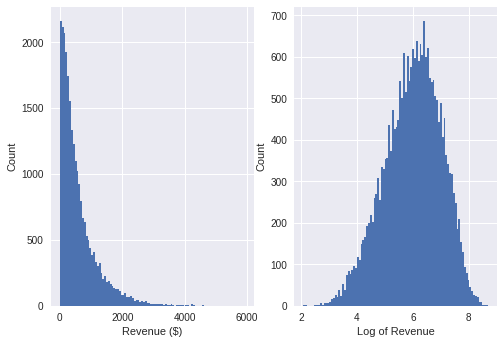

In [25]:
i=0
revenue_wpromo=[]
for price in rented_data_select['RentRate']:
    discount=promo_cost_factor[rented_data_select.iloc[i]['Promotion Name']]*price
    revenue=price*rent_length_select[i]-discount
    revenue_wpromo.append(revenue)
    i += 1

print('Plots showing the distribution of revenue from customers receiving promotions')
plt.subplot(1,2,1)
plt.hist(revenue_wpromo,100)
plt.xlabel('Revenue ($)')
plt.ylabel('Count')

import math
plt.subplot(1,2,2)
logval=[np.log(y) for y in revenue_wpromo if y>0]
plt.hist(logval,100)
plt.xlabel('Log of Revenue')
plt.ylabel('Count')

plt.show()

revenue_wpromo=[y for y in revenue_wpromo if y > 0]

To compare the distributions of revenues, we are going to use Bayesian inference method. 

In [26]:
import pymc3 as pm3
with pm3.Model() as model:
    
    # prior mean and standard deviation values
    mu1 = pm3.Normal('mu1',np.mean(np.log(revenue_wpromo)),1)  
    std1 = pm3.Normal('std1',np.std(np.log(revenue_wpromo)),1)  
    mu2 = pm3.Normal('mu2',np.mean(np.log(revenue_nopromo)),1)  
    std2 = pm3.Normal('std2',np.std(np.log(revenue_nopromo)),1)  
    
    # likelihood 
    # lognormal because revenue is greater than 0 and revenue is a product of rent/month and # of month
    obs1 = pm3.Lognormal('obs1',mu=mu1,sd=std1,observed=revenue_wpromo)
    obs2 = pm3.Lognormal('obs2',mu=mu2,sd=std2,observed=revenue_nopromo)
    
    # Compare mean value of the two distributions
    uplift = pm3.Deterministic('uplift',mu1 - mu2)
    
    # generate samples
    step = pm3.NUTS()
    trace = pm3.sample(10000,step=step)

100%|██████████| 10500/10500 [00:26<00:00, 400.25it/s]


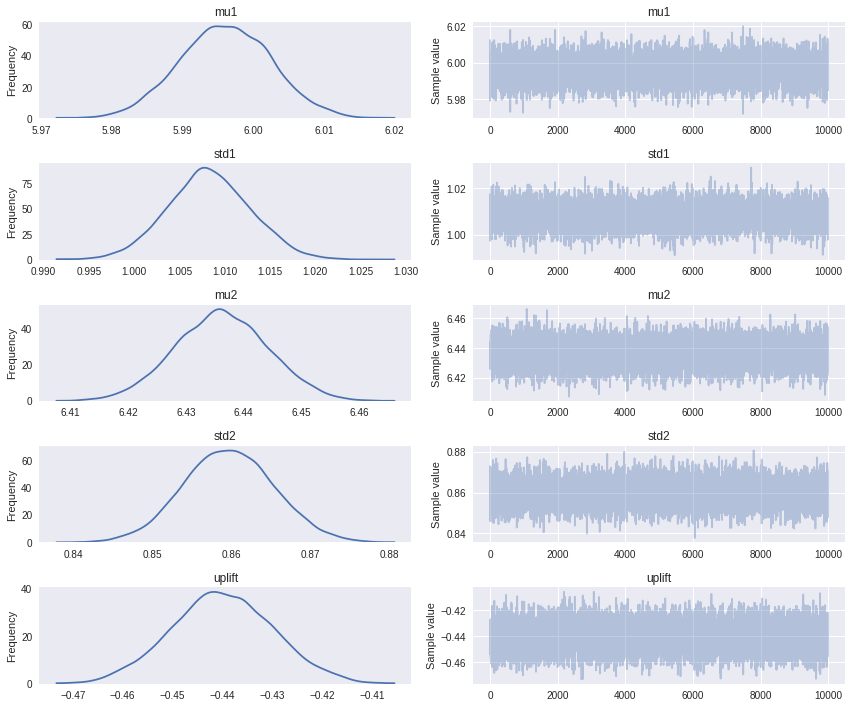

In [27]:
pm3.traceplot(trace);
plt.show()

In [28]:
print("mean of uplift : %.3f"%trace['uplift'].mean())
print("95% confidence of uplift: ",pm3.stats.hpd(trace['uplift'], alpha=0.05))

print("Convert to original")

i=(np.exp(pm3.stats.hpd(trace['uplift'], alpha=0.05)[0]))
j=(np.exp(pm3.stats.hpd(trace['uplift'], alpha=0.05)[1]))

print("Mean revenue of rentals from promotion is between %.2f%%  and %.2f%% of the revenue without promotion"%(i*100,j*100))

mean of uplift : -0.440
95% confidence of uplift:  [-0.45971393 -0.41962855]
Convert to original
Mean revenue of rentals from promotion is between 63.15%  and 65.73% of the revenue without promotion


With PyMC3 module, we can estimate the parameters such as mean and standard deviation of the log of revenue values between those had promotions and those without. The value of "uplift" is the difference in the mean values. The fact that it is negative (-0.44) means the revenues from those with promotion is smaller than those without promotion. The confidence interval for "uplift" is (-0.46, -0.42) which are also negative, and this gives a high confidence that the mean revenues are less when promotions were given. 